In [653]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from typing import Literal
%matplotlib inline

In [654]:
def f(x):
  return 3*x**2 - 4*x + 5

In [655]:
f(3.0)

20.0

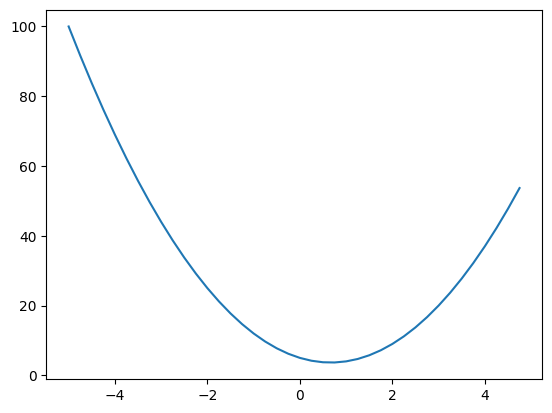

In [656]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [657]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [658]:
print(f"f(x) = {f(x)} \nf(x + h) = {f(x + h)}\nDifference = {f(x + h) - f(x)}\nGradient = {(f(x + h) - f(x))/h}")

f(x) = 3.666666666666667 
f(x + h) = 3.6666666666696663
Difference = 2.999378523327323e-12
Gradient = 2.999378523327323e-06


In [659]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)


4.0


#### Exercise
<b> A, B, C değerlerinde değişim olduğunda D bu değişimlerden ne kadar etkilenir? </b>

#### h => Değişim Miktari

In [660]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c # 1. Değer

c += h # c değişimi

d2 = a*b + c # 2. Değer

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Value Sınıfının Oluşturulması

In [661]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)
  
  def __rsub__(self, other): # other - self
    return other + (-self)

  def __radd__(self, other): # other + self
    return self + other
  
  def log(self):
      x = max(self.data, 1e-8)
      t = math.log(x)
      out = Value(t, (self,), 'log')

      def _backward():
          self.grad += out.grad / x
      out._backward = _backward

      return out
    

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def relu(self):
    x = self.data
    t = x if (x > 0) else 0
    out = Value(t, (self, ), 'ReLu')

    def _backward():
      self.grad += (1.0 if x > 0 else 0.0) * out.grad
    out._backward = _backward

    return out

  def sigmoid(self):
    x = self.data
    t = 1 / (1 + math.exp(-x))
    out = Value(t, (self, ), 'sigmoid')
    
    def _backward():
      self.grad += t * (1 - t) * out.grad
    out._backward = _backward

    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [662]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'; L.grad = 1.0  # L aslında loss fonksiyonu temsil eder. İşlemi başlatmak için L.grad = 1.0 yapılır.
L

Value(data=-8.0, grad=1.0)

In [663]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

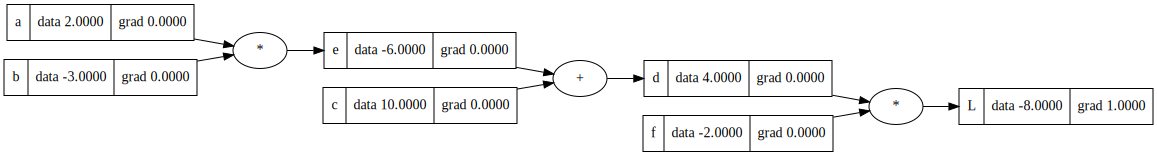

In [664]:
draw_dot(L)

#### Hesaplamalar

GRAD değerleri aslında inputumuzun Loss çıktısının ne kadar değiştirdiğini temsil eder. Bu da L'ye göre türev alınmasından gelir.

Örnek:
    L değerinin Grad değeri 1.
    L = d * f

    dL/dd = d(d * f) / d(d) => f/1 = f 

    Aslında burada d değerinin Grad değeri çarpıldığı diğer değerin değerine eşittir.
    Aynı şekilde;

    f.grad = dL / df
    L = d * f

    dL/df = d(d * f) / d(f) => d/1 = d

d.grad = f.data
f.grad = d.data

İkinci aşamada bir üste çıkılır.

hedefimiz dL/de değerini bulmak ancak direkt olarak L değerine erişimimiz yok bu durumda chain rule devreye girer.

https://en.wikipedia.org/wiki/Chain_rule

Chain Ruleye göre dL/de = (dL/dd) * (dd/de) değeridir. Biz zaten (dL/dd) değerini biliyoruz. Dolayısıyla (dd/de) değeriyle d.grad değerini çarpmamız gerekir.

dd/de = d(e + c) / d(e) = 1 * d.grad

d.grad = d.grad

#### "*" Operatorunun İşlevi
Çarpma işlemi, gradyanı değiştirir.

Gradyanı karşıdaki girişin değeriyle çarparak aktarır.
Her bir değişkenin çıktıya etkisi, diğerinin büyüklüğüne bağlıdır.

#### “+” Operatörünün Özelliği:
Toplama işleminin önemli özelliği, türevinin her giriş için 1 olmasıdır.
Yani, bir toplama düğümünden gradyan geri akar ve bire bir olarak girişlere dağılır.

Bu yüzden:
Toplama işlemi gradyanı değiştirmez.
Sadece gradyanı ikiye kopyalar ve iki tarafa yollar.
Toplama işlemi gradyanı değiştirmez, aynen geçirir.


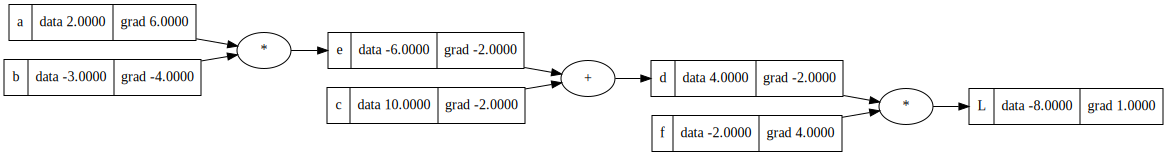

In [665]:
L.backward()

draw_dot(L)


a.data += 0.01 * a.grad  # a += 0.01 * 6.0 -> 2.06 olur

b.data += 0.01 * b.grad  # b += 0.01 * -4.0 -> -3.04 olur

c.data += 0.01 * c.grad  # c += 0.01 * -2.0 -> 9.98 olur

f.data += 0.01 * f.grad  # f += 0.01 * 4.0 -> -1.96 olur

İlk değerlerle L = -8.0 idi. Ancak parametrelerin güncellenmesi sonrası L ≈ -7.2865 oldu. Bu, gradient descent'in öğrenme adımıdır.

Gradient yönünde küçük bir adım atıldı, ve L değeri biraz daha az negatif oldu — yani optimizasyon hedefi olan L minimize edilmeye başlandı.

In [666]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [667]:
def dummy_func():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  c.data += h
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
dummy_func()

-1.9999999999988916


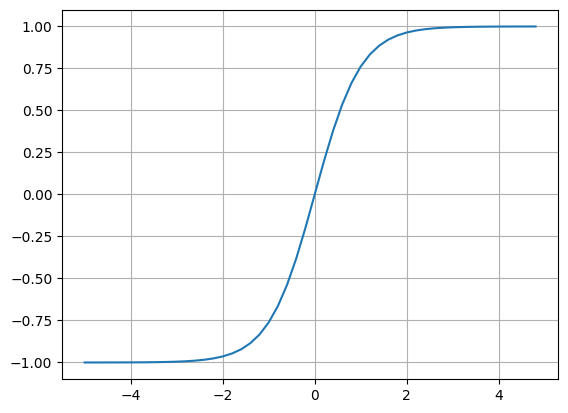

In [668]:
## Tanh Graph Presentation
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

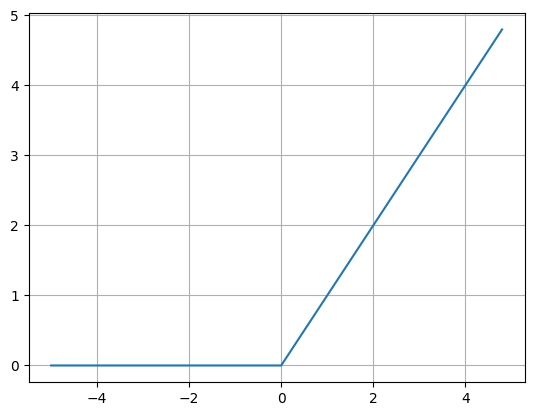

In [669]:
## Relu Graph Presentation
plt.plot(np.arange(-5,5,0.2), np.maximum(0, np.arange(-5,5,0.2))); plt.grid();


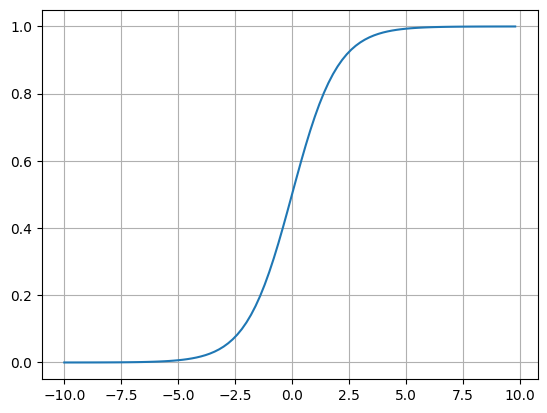

In [670]:
## Sigmoid Grahp Representation
plt.plot(np.arange(-10, 10, 0.2), 1 / (1 + np.exp(-np.arange(-10, 10, 0.2)))); plt.grid();

In [671]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') #Bias değeri
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

### tanh değerinin türevini almak

https://en.wikipedia.org/wiki/Activation_function

o = tanh(n)^2

DO/Dn = 1 - tanh(n)^2

DO / Dn = 1 - tanh(n)^2

DO / Dn = 1 - o^2

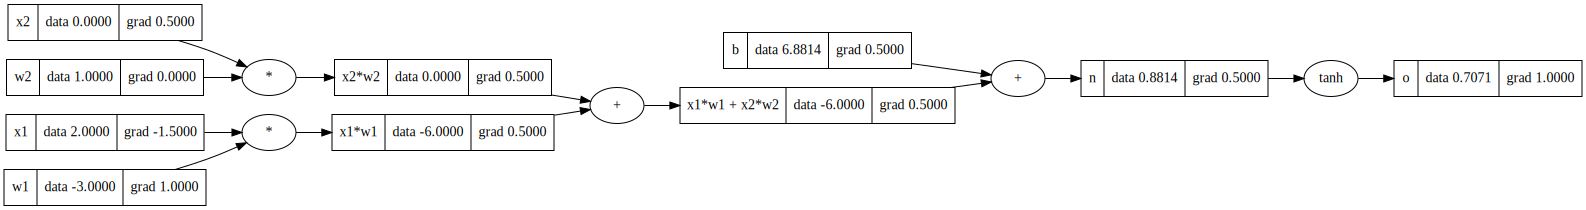

In [672]:
o.grad = 1.0

n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

draw_dot(o)

### Multi Layer Perceptron

In [673]:
# Weightler ve biasler random değerlerle başlar.
# Her bir değişkenin gradyanı hesaplanır.
# Gradyanlar güncellenir.
# Bu işlem bir epoch sayısı kadar tekrarlanır.

x = [2.0, 3.0, -4.0] # input listesi

class Neuron:
    def __init__(self, nin, activation: Literal["relu", "tanh","sigmoid"] = "tanh"): # nin => number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.activation = activation
        
    def __call__(self, x):
        act = sum((xi * wi for xi, wi in zip(x, self.w)), self.b)
        activations = {
            "relu": lambda v: v.relu(),
            "tanh": lambda v: v.tanh(),
            "sigmoid": lambda v: v.sigmoid()
        }
        out = activations[self.activation](act)
        return out
    
    def parameters(self):
        return self.w + [self.b]

n = Neuron(3)
n(x)

Value(data=0.9747616146532307, grad=0.0)

In [674]:
class Layer:
    def __init__(self, nin, nout, activation: Literal["relu", "tanh", "sigmoid"] = "tanh"):
        self.neurons = [Neuron(nin, activation) for _ in range(nout)]
        self.activation = activation

    def __repr__(self):
        return f"Layer(nin={len(self.neurons[0].w)}, nout={len(self.neurons)}, activation={self.activation})"
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

l = Layer(3, 4)
l(x)

[Value(data=-0.910649317501528, grad=0.0),
 Value(data=-0.8791298886307458, grad=0.0),
 Value(data=0.999568522750747, grad=0.0),
 Value(data=-0.9999801084739931, grad=0.0)]

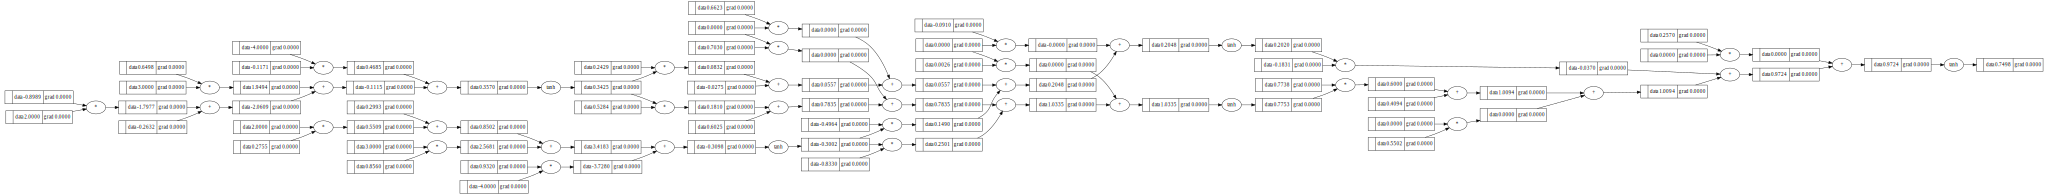

In [675]:
class MLP:
    def __init__(self, nin, nouts, activation: Literal["relu", "tanh","sigmoid"] = "tanh"):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], activation) for i in range(len(nouts))]
        self.activation = activation
        self._dropout_rate = 0.0
        self._dropout_mask = None
        
    def __call__(self, x, training=False):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if training and self._dropout_rate > 0 and i < len(self.layers) - 1:
                if isinstance(x, list):
                    mask = np.random.binomial(1, 1 - self._dropout_rate, size=len(x))
                    x = [xi if m else Value(0.0) for xi, m in zip(x, mask)]
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def dropout(self, rate: float):
        assert 0.0 <= rate < 1.0, "Dropout rate must be in [0, 1)"
        self._dropout_rate = rate
        

m = MLP(3, [4, 4, 1], activation="tanh") # 3 input, 4 hidden layer, 1 output
m.dropout(0.5)
out = m(x, training=True) ## Returns the output of the MLP as Value Object

draw_dot(out)

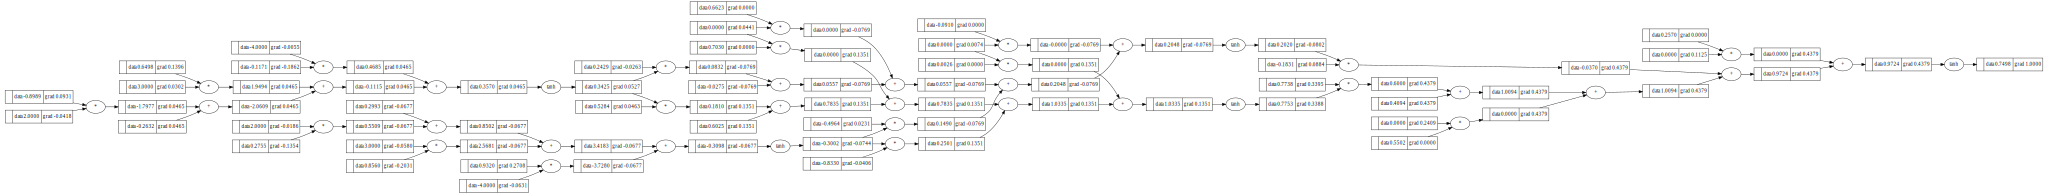

In [676]:
out.backward()

draw_dot(out)

### Final Step => Train The Model

In [677]:
xs = [
  [2.0, 3.0, -4.0],
  [1.0, -3.0, -2.0],
  [3.0, -1.0, 2.0],
  [-2.0, 4.0, 1.0]
] # input listesi

ys = [1.0, -1.0, 1.0, -1.0] # beklenen çıktılar
yp = [m(x) for x in xs] # tahmin edilen çıktılar
yp


[Value(data=0.6308447733483482, grad=0.0),
 Value(data=0.7357521348474219, grad=0.0),
 Value(data=0.5509564814404038, grad=0.0),
 Value(data=0.4262082350083907, grad=0.0)]

### Mean Squared Error Loss

https://www.britannica.com/science/mean-squared-error

In [678]:
values = [(yout - ygt)**2 for yout, ygt in zip(yp, ys)] # mean squared error
print(f"Values => {values}")

loss = sum(values)
loss

Values => [Value(data=0.1362755813642324, grad=0.0), Value(data=3.0128354736273826, grad=0.0), Value(data=0.20164008156038243, grad=0.0), Value(data=2.034069929605749, grad=0.0)]


Value(data=5.3848210661577465, grad=0.0)

In [679]:
def binary_cross_entropy(y_preds, y_trues):
    eps = 1e-8 
    losses = [-(yt * (yp + eps).log() + (1 - yt) * (1 - yp + eps).log()) for yp, yt in zip(y_preds, y_trues)]
    return sum(losses) * (1.0 / len(losses))

ys_val = [Value(y) for y in ys]
loss_bce = binary_cross_entropy(yp, ys_val)
print("Binary Cross Entropy Loss:", loss_bce)

Binary Cross Entropy Loss: Value(data=0.9174546217995346, grad=0.0)


In [680]:
loss.backward()


In [681]:
m.layers[0].neurons[0].w[0].grad

-0.22457331315116696

In [682]:
m.layers[0].neurons[0].w[0].data

-0.8988687439121219

In [683]:
# draw_dot(loss)


In [684]:
# Neden -0.01?
# Gradyanların tersi yönünde bir adım atıp değerleri güncelliyoruz.
# loss fonksiyonunu minimize etmeye çalışıyoruz.

for p in m.parameters():
  p.data += -0.01 * p.grad # -0.01 => learning rate

In [685]:
m.layers[0].neurons[0].w[0].data

-0.8966230107806102

In [686]:
for epoch in range(20):
    # forward pass
    yp = [m(x) for x in xs]
    # loss
    loss = sum((yout - ygt)**2 for yout, ygt in zip(yp, ys))
    # Zeroing the gradients
    for p in m.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()
    # update parameters
    for p in m.parameters():
        p.data += -0.01 * p.grad

    print(f"Epoch {epoch+1}, Loss: {loss.data}")

Epoch 1, Loss: 5.166210303131431
Epoch 2, Loss: 4.9697205537367575
Epoch 3, Loss: 4.788838409141684
Epoch 4, Loss: 4.625131535725947
Epoch 5, Loss: 4.477881281918728
Epoch 6, Loss: 4.344945197567666
Epoch 7, Loss: 4.223566756883413
Epoch 8, Loss: 4.110940760087531
Epoch 9, Loss: 4.004534002542185
Epoch 10, Loss: 3.9022344647360905
Epoch 11, Loss: 3.802402924515471
Epoch 12, Loss: 3.7038765667239524
Epoch 13, Loss: 3.6059492613436865
Epoch 14, Loss: 3.508335426497124
Epoch 15, Loss: 3.4111148671610803
Epoch 16, Loss: 3.314654141647583
Epoch 17, Loss: 3.219504669630607
Epoch 18, Loss: 3.1262863885010117
Epoch 19, Loss: 3.0355739724709343
Epoch 20, Loss: 2.947805719800223


In [687]:
## Son durumda değerlerimize bakalım
yp

[Value(data=0.3759630587100136, grad=-1.2480738825799729),
 Value(data=0.18704006327269151, grad=2.3740801265453833),
 Value(data=0.3825897546132065, grad=-1.2348204907735871),
 Value(data=-0.12357311041784845, grad=1.752853779164303)]

@credit
Andrej Karpathy
The spelled-out intro to neural networks and backpropagation: building micrograd

https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ